# Setup

In [1]:
!pip -q install yfinance arch numpy pandas matplotlib scipy

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from arch import arch_model

pd.options.display.float_format = "{:,.6f}".format
np.set_printoptions(precision=6, suppress=True)

# Parameters
TICKER     = "BARC.L"     # Barclays (LSE)
SHARES     = 100          # long 100 shares for stock VaR/P&L
ALPHAS     = [0.90, 0.95, 0.99]
LAMBDA     = 0.94         # EWMA decay
RF_ANNUAL  = 0.0343       # SONIA ~3.43% (adjust Rf if needed)
DIV_YIELD  = 0.00         # simplify to 0
SEED       = 42; np.random.seed(SEED)

# In-sample = last two *complete* calendar years
# Out-of-sample = current year to date
today = pd.Timestamp.today().normalize()
last_year_end = (today.to_period("Y") - 1).to_timestamp("Y")      # Dec 31 of last year
prev_year_start = (last_year_end.to_period("Y") - 1).to_timestamp("Y").replace(month=1, day=1)
IN_START, IN_END = prev_year_start.date(), last_year_end.date()

# OOS from Jan 1 of current year to today
OOS_START, OOS_END = last_year_end.replace(month=12, day=31) + pd.Timedelta(days=1), today
OOS_START, OOS_END = OOS_START.date(), OOS_END.date()

print("In-sample:", IN_START, "→", IN_END)
print("Out-of-sample:", OOS_START, "→", OOS_END)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 3.6 MB/s eta 0:00:00
In-sample: 2023-01-01 → 2024-12-31
Out-of-sample: 2025-01-01 → 2025-08-30


# Helpers

In [2]:
# Helpers to handle Series/scalars

def as_series(x):
    """Ensure a 1-D pandas Series (squeeze 1-col DataFrame)."""
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            return x.iloc[:, 0]
        raise ValueError("Expected a 1-D Series but got a DataFrame with >1 columns.")
    return pd.Series(x) if not isinstance(x, pd.Series) else x

def to_scalar(x):
    """Return a float from numpy/pandas scalar-ish values (no FutureWarnings)."""
    import numpy as np
    if isinstance(x, (float, int, np.floating, np.integer)):
        return float(x)
    if isinstance(x, (pd.Series, pd.Index)) and len(x) == 1:
        return float(x.iloc[0])
    if isinstance(x, pd.DataFrame) and x.size == 1:
        return float(x.iloc[0, 0])
    return float(x)

# Basic quant helpers

def daily_log_returns(px: pd.Series) -> pd.Series:
    return np.log(px).diff().dropna()

def ewma_sigma_last(r: pd.Series, lam=0.94) -> float:
    """One-step-ahead daily sigma from EWMA variance."""
    r = as_series(r).dropna()
    v = 0.0
    for x in r.values:
        v = lam*v + (1-lam)*x*x
    return float(np.sqrt(v))

def kupiec_pof(violations: int, n: int, alpha: float) -> float:
    """Kupiec POF likelihood-ratio for unconditional coverage."""
    if n == 0:
        return np.nan
    p = 1 - alpha
    if not (0 < violations < n):  # boundary cases not informative
        return np.nan
    phat = violations / n
    ll0 = (1-p)**(n-violations) * (p**violations)
    ll1 = (1-phat)**(n-violations) * (phat**violations)
    return float(-2*np.log(ll0/ll1))

def var_es_normal(mu: float, sigma: float, alpha: float):
    """Parametric VaR/ES for log returns."""
    z = norm.ppf(1 - alpha)
    var = mu + sigma*z
    es  = mu - sigma * norm.pdf(z) / (1 - alpha)
    return float(var), float(es)

def var_es_hist(r, alpha: float):
    """Historical VaR/ES on a 1-D return series (robust)."""
    r = as_series(r).dropna().sort_values()
    q = r.quantile(1 - alpha, interpolation="lower")
    mask = r <= q
    es = r[mask].mean() if bool(mask.any()) else q
    return float(q), float(es)

def rolling_ewma_annualized(r: pd.Series, lam=0.94) -> pd.Series:
    """Rolling EWMA annualized vol series (uses info up to each day)."""
    r = as_series(r).dropna()
    vals, out = 0.0, []
    for x in r.values:
        vals = lam*vals + (1-lam)*x*x
        out.append(np.sqrt(vals) * np.sqrt(252))  # annualized
    return pd.Series(out, index=r.index)


# Download data & split IS/OOS

In [3]:
px = yf.download(TICKER, start=IN_START, end=OOS_END, auto_adjust=True, progress=False)["Close"].dropna()
ret = daily_log_returns(px)  # log daily (Series)

# force 1-D Series
ret  = as_series(ret)

r_in  = as_series(ret.loc[str(IN_START):str(IN_END)].copy())
r_oos = as_series(ret.loc[str(OOS_START):str(OOS_END)].copy())

# Price references
# Use Timestamps (not strings) for index lookup
IN_END_TS   = pd.Timestamp(IN_END)
OOS_START_TS = pd.Timestamp(OOS_START)

# px is a 1-column DataFrame; .loc[date] returns a 1-element Series.
# Use column selection to get a true scalar
col0 = px.columns[0]

# price at end of in-sample
S_in_end = float(px.loc[IN_END_TS, col0])

# price at OOS start (exact if present, otherwise nearest)
if OOS_START_TS in px.index:
    S_oos_beg = float(px.loc[OOS_START_TS, col0])
else:
    nearest_pos = px.index.get_indexer([OOS_START_TS], method="nearest")[0]
    S_oos_beg = float(px.iloc[nearest_pos, 0])

print("S(IS end):", S_in_end, " | S(OOS start):", S_oos_beg)

# sanity
print("px:", type(px), px.shape)
print("ret:", type(ret), getattr(ret, "shape", None))
print("r_in:", type(r_in), getattr(r_in, "shape", None))
print("r_oos:", type(r_oos), getattr(r_oos, "shape", None))


S(IS end): 268.0802307128906  | S(OOS start): 266.8305358886719
px: <class 'pandas.core.frame.DataFrame'> (672, 1)
ret: <class 'pandas.core.series.Series'> (671,)
r_in: <class 'pandas.core.series.Series'> (504,)
r_oos: <class 'pandas.core.series.Series'> (167,)


# Vol forecasting - Maximum Likelihood (ML), EWMA, GARCH

In [4]:
# ML (sample)
mu_ml   = r_in.mean()
sig_ml  = r_in.std()

# EWMA (RiskMetrics)
sig_ewma = ewma_sigma_last(r_in, lam=LAMBDA)   # daily

# GARCH(1,1) with t innovations (arch uses percent returns)
am = arch_model(r_in.values*100, vol="GARCH", p=1, q=1, mean="constant", dist="t")
res = am.fit(disp="off")
garch_var = res.forecast(horizon=1).variance.values[-1,0]   # percent^2
sig_garch = float(np.sqrt(garch_var)/100.0)                 # daily
mu_garch  = float(res.params["mu"]/100.0)                   # daily mean

print("Daily sigma — ML:", sig_ml, " | EWMA:", sig_ewma, " | GARCH:", sig_garch)


Daily sigma — ML: 0.018430131062689856  | EWMA: 0.0137548887483242  | GARCH: 0.017414449644869056


# One-day stock VaR/ES (Normal ML/EWMA/GARCH + Historical) & Kupiec tests

In [5]:
# Coerce params to clean scalars
mu_ml_s     = to_scalar(mu_ml)
sig_ml_s    = to_scalar(sig_ml)
sig_ewma_s  = to_scalar(sig_ewma)
mu_garch_s  = to_scalar(mu_garch)
sig_garch_s = to_scalar(sig_garch)

# VaR/ES table
rows=[]
for name,(mu,sig) in {
    "Normal-ML":    (mu_ml_s,    sig_ml_s),
    "Normal-EWMA":  (0.0,        sig_ewma_s),
    "Normal-GARCH": (mu_garch_s, sig_garch_s)
}.items():
    for a in ALPHAS:
        v,e = var_es_normal(mu, sig, a)
        rows.append([name, a, v, e])

stock_var_param = pd.DataFrame(rows, columns=["Model","Alpha","VaR (log r)","ES (log r)"])

rows=[]
for a in ALPHAS:
    v,e = var_es_hist(r_in, a)
    rows.append(["Historical", a, v, e])
stock_var_hist = pd.DataFrame(rows, columns=["Model","Alpha","VaR (log r)","ES (log r)"])

stock_var_table = pd.concat([stock_var_param, stock_var_hist], ignore_index=True)
display(stock_var_table)


,Model,Alpha,VaR (log r),ES (log r)
0,Normal-ML,0.900000,-0.022637,-0.031362
1,Normal-ML,0.950000,-0.029333,-0.037034
2,Normal-ML,0.990000,-0.041893,-0.048138
3,Normal-EWMA,0.900000,-0.017628,-0.024140
4,Normal-EWMA,0.950000,-0.022625,-0.028372
5,Normal-EWMA,0.990000,-0.031999,-0.036660
6,Normal-GARCH,0.900000,-0.020650,-0.028895
7,Normal-GARCH,0.950000,-0.026977,-0.034254
8,Normal-GARCH,0.990000,-0.038845,-0.044746
9,Historical,0.900000,-0.020625,-0.033045


In [6]:
# Backtest exceedances on OOS
def exceed_table_stock(r_oos, r_in, mu_ml, sig_ml, mu_garch, sig_garch, sig_ewma):
    rows=[]
    models = {
        "Normal-ML":    (mu_ml,    sig_ml),
        "Normal-EWMA":  (0.0,      sig_ewma),
        "Normal-GARCH": (mu_garch, sig_garch)
    }
    for name,(mu,sig) in models.items():
        for a in ALPHAS:
            v,_ = var_es_normal(mu, sig, a)
            hits = int((r_oos < v).sum())
            LR = kupiec_pof(hits, len(r_oos), a)
            rows.append([name,a,hits,(1-a)*len(r_oos),v,LR])

    for a in ALPHAS:
        v,_ = var_es_hist(r_in, a)
        hits = int((r_oos < v).sum())
        LR = kupiec_pof(hits, len(r_oos), a)
        rows.append(["Historical",a,hits,(1-a)*len(r_oos),v,LR])

    return pd.DataFrame(rows, columns=["Model","Alpha","Exceed (OOS)","Expected","VaR threshold (log r)","Kupiec LR"])

bt_stock = exceed_table_stock(r_oos, r_in, mu_ml_s, sig_ml_s, mu_garch_s, sig_garch_s, sig_ewma_s)
display(bt_stock)


,Model,Alpha,Exceed (OOS),Expected,VaR threshold (log r),Kupiec LR
0,Normal-ML,0.900000,16,16.700000,-0.022637,0.033015
1,Normal-ML,0.950000,11,8.350000,-0.029333,0.808455
2,Normal-ML,0.990000,6,1.670000,-0.041893,6.801636
3,Normal-EWMA,0.900000,21,16.700000,-0.017628,1.146987
4,Normal-EWMA,0.950000,17,8.350000,-0.022625,7.352794
5,Normal-EWMA,0.990000,9,1.670000,-0.031999,15.989109
6,Normal-GARCH,0.900000,18,16.700000,-0.020650,0.109946
7,Normal-GARCH,0.950000,12,8.350000,-0.026977,1.488108
8,Normal-GARCH,0.990000,7,1.670000,-0.038845,9.576920
9,Historical,0.900000,18,16.700000,-0.020625,0.109946


# Options: Strategy N (short call) VaR via δ–γ–θ, daily re-pricing; Strategy H (delta-hedged) with daily re-hedge; cash accrual; exceedances vs VaR(N)

In [7]:
from math import exp, sqrt, log

def bs_call_price(S, K, T, r, q, sigma):
    # T in years; r, q cont.-comp.; sigma annualized
    if T <= 0 or sigma <= 0:
        return max(0.0, S*exp(-q*T) - K*exp(-r*T))
    d1 = (log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return exp(-q*T)*S*norm.cdf(d1) - exp(-r*T)*norm.cdf(d2)

def bs_call_greeks(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0:
        return 0.0, 0.0, 0.0
    d1 = (log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    delta = exp(-q*T)*norm.cdf(d1)
    gamma = exp(-q*T)*norm.pdf(d1)/(S*sigma*sqrt(T))
    # calendar-time theta (per year); we'll scale by Δt=1/252 per day
    theta = r*bs_call_price(S,K,T,r,q,sigma) - (r - q)*S*delta - 0.5*sigma*(S**2)*gamma
    return float(delta), float(gamma), float(theta)


# Initial option (ATM at end of IS) & Strategy-N VaR via δ–γ–θ

In [8]:
S0 = S_in_end
K  = S0                       # ATM
T_one_day = 1/252.0
sigma_ann = sig_ewma_s * sqrt(252)   # annualized EWMA for option

C0 = bs_call_price(S0, K, T_one_day, RF_ANNUAL, DIV_YIELD, sigma_ann)
Delta0, Gamma0, Theta0 = bs_call_greeks(S0, K, T_one_day, RF_ANNUAL, DIV_YIELD, sigma_ann)

print(f"Initial call: S0={S0:.4f}, K={K:.4f}, C0={C0:.6f}, Δ0={Delta0:.6f}, Γ0={Gamma0:.6e}, Θ0/yr={Theta0:.6f}")


Initial call: S0=268.0802, K=268.0802, C0=135.332734, Δ0=0.506691, Γ0=1.081751e-01, Θ0/yr=-848.775498


In [9]:
def stock_var_price_shock(S, sigma_daily, alpha):
    """One-day log-return VaR threshold → price change (loss scenario)."""
    var_log, _ = var_es_normal(0.0, sigma_daily, alpha)  # negative
    dS = S*(np.exp(var_log) - 1.0)
    return var_log, dS

rows=[]
for a in ALPHAS:
    var_log, dS = stock_var_price_shock(S0, sig_ewma_s, a)  # use Normal-EWMA shock
    # δ–γ–θ on SHORT call: P&L ≈ -[ -Δ dS - 0.5 Γ dS^2 - Θ * Δt ]
    pnl_option = -(-Delta0*dS - 0.5*Gamma0*(dS**2) - Theta0*(1/252))
    theta_deposit = exp(RF_ANNUAL*(1/252))*C0 - C0  # interest on option premium for one day
    var_N = pnl_option - theta_deposit
    rows.append([a, var_log, dS, pnl_option, theta_deposit, var_N])

varN_table = pd.DataFrame(rows, columns=["Alpha","VaR log r","ΔS","δγθ P&L (option)","Theta deposit","One-day VaR Strategy N"])
display(varN_table)

# choose thresholds for backtest (we’ll keep all; typically use 95%)
VaR_N_for_backtest = dict(zip(varN_table["Alpha"], varN_table["One-day VaR Strategy N"]))
print("VaR(N) thresholds to use (per day):", VaR_N_for_backtest)


,Alpha,VaR log r,ΔS,δγθ P&L (option),Theta deposit,One-day VaR Strategy N
0,0.900000,-0.017628,-4.684204,-4.554825,0.018422,-4.573247
1,0.950000,-0.022625,-5.997158,-4.461557,0.018422,-4.479978
2,0.990000,-0.031999,-8.442414,-3.790800,0.018422,-3.809221


VaR(N) thresholds to use (per day): {0.9: -4.573246934522799, 0.95: -4.47997821446096, 0.99: -3.8092210653962644}


# Rolling OOS backtest - daily re-pricing with rolling EWMA vol; cash accrual; daily delta re-hedge

,Strategy N (short call)
count,167.000000
mean,-1.341721
std,41.776933
min,-271.295750
25%,-4.324644
50%,-0.952593
75%,3.300424
max,232.130951


,Strategy H (delta-hedged)
count,167.000000
mean,-1.018816
std,40.241556
min,-271.295750
25%,-0.000005
50%,0.000000
75%,0.000000
max,225.044188


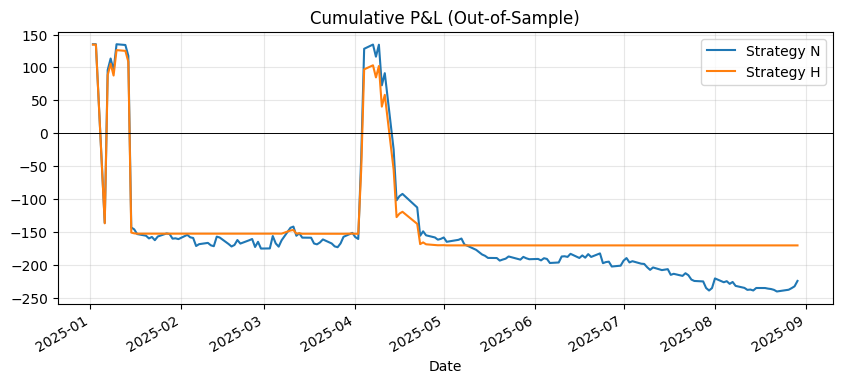

In [10]:
# 1) Normalize price objects to Series and build aligned OOS slices
IN_END_TS    = pd.Timestamp(IN_END)
OOS_START_TS = pd.Timestamp(OOS_START)

# px is (671, 1) DataFrame in your run → squeeze to Series
px_s = px.iloc[:, 0] if isinstance(px, pd.DataFrame) else px

# OOS price series
px_oos_s = px_s.loc[OOS_START_TS:].copy()

# Rolling annualized EWMA vol for OOS pricing (no look-ahead)
ewma_ann = rolling_ewma_annualized(ret.loc[OOS_START_TS:], lam=LAMBDA)

# Align dates (intersection) so both have values every day of the loop
dates = px_oos_s.index.intersection(ewma_ann.index)
px_oos_s = px_oos_s.reindex(dates)
ewma_ann = ewma_ann.reindex(dates)

# 2) Backtest with scalar-safe access
def strategy_backtest(px_oos_series: pd.Series, ewma_ann_series: pd.Series, K, rf_annual, q=0.0):
    """
    Returns:
      pnl_N: daily P&L for Strategy N (short call; mtm + cash accrual)
      pnl_H: daily P&L for Strategy H (short call + long Δ shares; daily re-hedge + cash accrual)
    """
    dates_local = px_oos_series.index
    if len(dates_local) < 2:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # Initial state at end of in-sample (scalar-safe)
    S_prev = float(px_s.at[IN_END_TS])
    C_prev = bs_call_price(S_prev, K, 1/252, rf_annual, q, sigma_ann)
    Delta_prev, _, _ = bs_call_greeks(S_prev, K, 1/252, rf_annual, q, sigma_ann)

    # Cash accounts
    cash_N = C_prev
    cash_H = C_prev - Delta_prev * S_prev
    shares_H = Delta_prev

    pnl_list_N, pnl_list_H = [], []

    for d in dates_local:
        # Scalars with .at[...] to avoid FutureWarnings
        S_t     = float(px_oos_series.at[d])
        sigma_t = float(ewma_ann_series.at[d])

        C_t = bs_call_price(S_t, K, 1/252, rf_annual, q, sigma_t)
        Delta_t, _, _ = bs_call_greeks(S_t, K, 1/252, rf_annual, q, sigma_t)

        # Strategy N
        pnl_opt_N  = -(C_t - C_prev)                # mtm on short call
        cash_N    *= np.exp(rf_annual*(1/252))      # interest accrual
        cash_N    += pnl_opt_N
        pnl_list_N.append(pnl_opt_N)

        # Strategy H
        pnl_opt_H  = -(C_t - C_prev)
        pnl_shares = shares_H * (S_t - S_prev)
        cash_H    *= np.exp(rf_annual*(1/252))
        # re-hedge to new delta
        trade_shares = Delta_t - shares_H
        cash_H      -= trade_shares * S_t
        pnl_total_H  = pnl_opt_H + pnl_shares
        cash_H      += pnl_total_H
        pnl_list_H.append(pnl_total_H)

        # update state
        shares_H = Delta_t
        S_prev, C_prev = S_t, C_t

    pnl_N = pd.Series(pnl_list_N, index=dates_local, name="Strategy N (short call)")
    pnl_H = pd.Series(pnl_list_H, index=dates_local, name="Strategy H (delta-hedged)")
    return pnl_N, pnl_H

# Run the fixed backtest
pnl_N, pnl_H = strategy_backtest(px_oos_s, ewma_ann, K, RF_ANNUAL, q=DIV_YIELD)

display(pnl_N.describe(), pnl_H.describe())

plt.figure(figsize=(10,4))
pnl_N.cumsum().plot(label="Strategy N")
pnl_H.cumsum().plot(label="Strategy H")
plt.title("Cumulative P&L (Out-of-Sample)")
plt.axhline(0, color="k", lw=0.7)
plt.legend(); plt.grid(True, alpha=.3); plt.show()


# Exceedances for both strategies using same Var(N) thresholds

In [11]:
def exceedances_from_varN(pnl_series: pd.Series, VaR_N_per_day: float) -> int:
    losses = -as_series(pnl_series)  # loss = -P&L
    return int((losses > VaR_N_per_day).sum())

rows=[]
for a in ALPHAS:
    thr = VaR_N_for_backtest[a]
    exN = exceedances_from_varN(pnl_N, thr)
    exH = exceedances_from_varN(pnl_H, thr)
    exp_days = (1-a)*len(pnl_N)
    rows.append([a, thr, exN, exH, exp_days])

ex_table = pd.DataFrame(rows, columns=["Alpha","VaR(N) per day","Exceedances: Strategy N","Exceedances: Strategy H","Expected"])
display(ex_table)


,Alpha,VaR(N) per day,Exceedances: Strategy N,Exceedances: Strategy H,Expected
0,0.900000,-4.573247,135,156,16.700000
1,0.950000,-4.479978,135,156,8.350000
2,0.990000,-3.809221,131,156,1.670000


# Distributions & VaR overlays

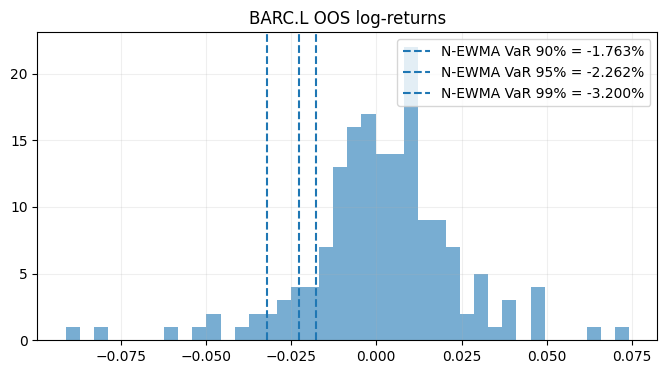

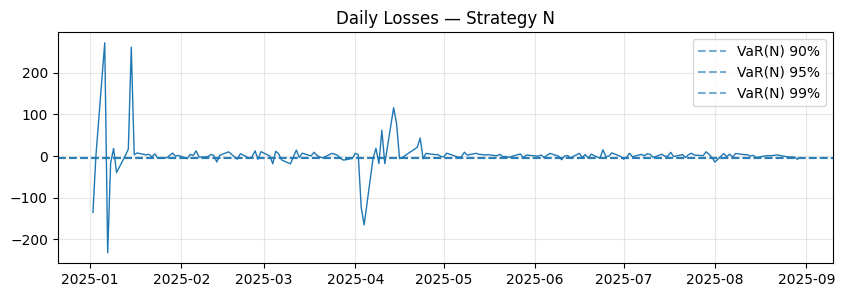

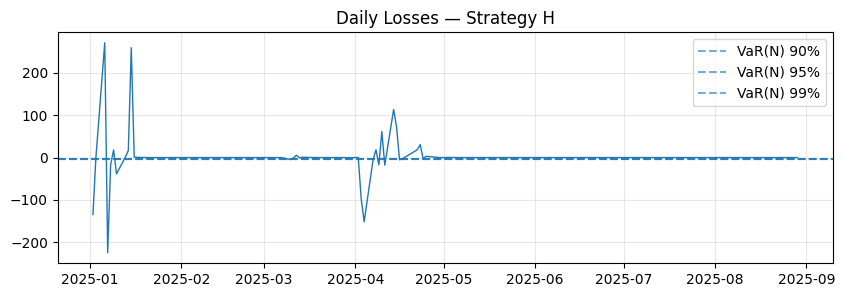

In [12]:
# OOS return histogram with Normal-EWMA VaR lines
plt.figure(figsize=(8,4))
r_oos.hist(bins=40, alpha=0.6, edgecolor="none")
for a in ALPHAS:
    v,_ = var_es_normal(0.0, sig_ewma_s, a)
    plt.axvline(v, ls="--", label=f"N-EWMA VaR {int(a*100)}% = {v:.3%}")
plt.title(f"{TICKER} OOS log-returns")
plt.legend(); plt.grid(True, alpha=.2); plt.show()

# Daily losses vs VaR(N)
for name, s in {"N": pnl_N, "H": pnl_H}.items():
    losses = -as_series(s)
    plt.figure(figsize=(10,3))
    plt.plot(losses.index, losses.values, lw=1)
    for a in ALPHAS:
        plt.axhline(VaR_N_for_backtest[a], ls="--", alpha=0.6, label=f"VaR(N) {int(a*100)}%")
    plt.title(f"Daily Losses — Strategy {name}")
    plt.legend(); plt.grid(True, alpha=.3); plt.show()
